# Calibration examples

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np

from becquerel import Calibration

%matplotlib inline
warnings.filterwarnings("ignore", category=DeprecationWarning)

The `Calibration` class is very general -- it is a function of a scalar that results in a scalar output. The function should be fully described by a formula and parametrized by a list of scalar parameters (`"p"`).

Here is what a linear calibration looks like:

In [2]:
cal = Calibration("p[0] + p[1] * x", [5.0, 0.15])
print(cal)
repr(cal)

expression:
    p[0] + p[1] * x
params (p):
    [5.   0.15]
domain:
    (np.float64(-1000000.0), np.float64(1000000.0))
range:
    (np.float64(-1000000.0), np.float64(1000000.0))



"Calibration('p[0] + p[1] * x', array([5.  , 0.15]), domain=(np.float64(-1000000.0), np.float64(1000000.0)), rng=(np.float64(-1000000.0), np.float64(1000000.0)))"

`Calibration`s are callable like functions, so `cal(x)` will return its value at `x`:

In [3]:
cal(10)

np.float64(6.5)

Often you may not know the function parameters ahead of time, but will want to fit the function to a set of calibration points. Here is how you fit an already-instantiated `Calibration`:

In [4]:
points_x = [100, 500, 1000, 1500, 2000, 3000]
points_y = [10, 50, 105, 160, 195, 310]

cal2 = cal.copy()
cal2.set_points(points_x, points_y)
cal2.fit()
print(cal2)

expression:
    p[0] + p[1] * x
params (p):
    [0.18535127 0.10233184]
domain:
    (np.float64(-1000000.0), np.float64(1000000.0))
range:
    (np.float64(-1000000.0), np.float64(1000000.0))
calibration points (x):
    [ 100.  500. 1000. 1500. 2000. 3000.]
calibration points (y):
    [ 10.  50. 105. 160. 195. 310.]
calibration weights:
    [1. 1. 1. 1. 1. 1.]



Shorter version:

In [5]:
cal2.fit_points(points_x, points_y)

How did we do?

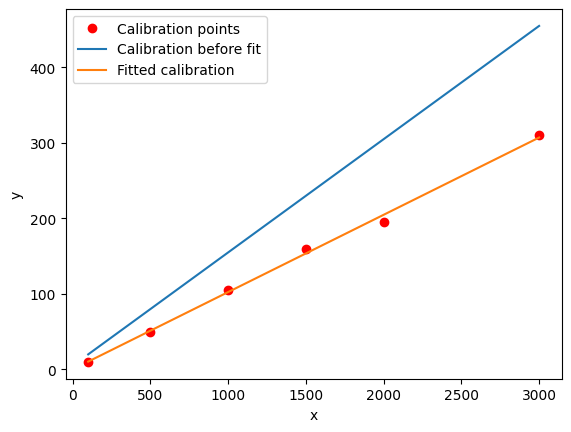

In [6]:
plt.figure()
plt.plot(points_x, points_y, "ro", label="Calibration points")
x_fine = np.linspace(min(points_x), max(points_x), num=1000)
plt.plot(x_fine, cal(x_fine), label="Calibration before fit")
plt.plot(x_fine, cal2(x_fine), label="Fitted calibration")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

You can also perform the fit while instantiating the object using `from_points`:

In [7]:
cal3 = Calibration.from_points(
    "p[0] + p[1] * x", points_x, points_y, params0=[5.0, 0.15]
)
print(cal3)

expression:
    p[0] + p[1] * x
params (p):
    [0.18535127 0.10233184]
domain:
    (np.float64(-1000000.0), np.float64(1000000.0))
range:
    (np.float64(-1000000.0), np.float64(1000000.0))
calibration points (x):
    [ 100.  500. 1000. 1500. 2000. 3000.]
calibration points (y):
    [ 10.  50. 105. 160. 195. 310.]
calibration weights:
    [1. 1. 1. 1. 1. 1.]



This code should produce an equivalent calibration as `fit()` does:

In [8]:
cal2 == cal3

True

# Auxiliary parameters

If your calibration function requires auxiliary parameters that will not be fit, they can be provided as `aux_params` and referred to in the expression as `"a"`:

In [9]:
cal = Calibration("a[0] + p[0] + p[1] * (x / a[1])", [5.0, 0.15], aux_params=[0.0, 1.0])
print(cal)

expression:
    a[0] + p[0] + p[1] * (x / a[1])
params (p):
    [5.   0.15]
auxiliary params (a):
    [0. 1.]
domain:
    (np.float64(-1000000.0), np.float64(1000000.0))
range:
    (np.float64(-1000000.0), np.float64(1000000.0))



# More complex calibration functions

Calibrations can include special functions, basically anything that `asteval` can handle, and all of `numpy` and `scipy`:

In [10]:
cal = Calibration(
    "p[0] + p[1] * x + p[2] * np.exp(x / p[3]) + p[4] * scipy.special.gammaln(x)",
    [5, 2, 3, 700, 1],
)
print(cal)
cal(10)

expression:
    p[0] + p[1] * x + p[2] * np.exp(x / p[3]) + p[4] * scipy.special.gammaln(x)
params (p):
    [  5   2   3 700   1]
domain:
    (np.float64(-1000000.0), np.float64(1000000.0))
range:
    (np.float64(-1000000.0), np.float64(1000000.0))



np.float64(40.84499220833462)

# Multiline expressions

The `expression` used in a calibration need not be confined to a single line, it can be an entire code block so long as it references the independent variable `"x"` and the parameters `"p"` and the final statement evaluates to the value of the function. For example, the following two calibrations produce equivalent results:

In [11]:
cal1 = Calibration("p[0] + p[1] * x + p[2] * x ** 2", [5.0, 2.0, 1e-2])
cal2 = Calibration(
    """
y = p[0]
y += p[1] * x
y += p[2] * x ** 2
y""",
    [5.0, 2.0, 1e-2],
)

x = np.linspace(0, 4000, num=1000)
assert np.allclose(cal1(x), cal2(x))

Although their output is the same, they will not satisfy equality because the expressions differ:

In [12]:
cal1 == cal2

False

# Special instantiation methods

There are factory class methods for `Calibration` that are meant to make the process of instantiation easier for certain types of calibration functions. For example, if you want a polynomial function of some order `n`, simply use `Calibration.from_polynomial` with `n + 1` parameters:

In [13]:
cal = Calibration.from_polynomial([5, 2, 3, 7, 1])
print(cal)

expression:
    p[0] + p[1] * x**1 + p[2] * x**2 + p[3] * x**3 + p[4] * x**4
params (p):
    [5 2 3 7 1]
domain:
    (np.float64(-1000000.0), np.float64(1000000.0))
range:
    (np.float64(-1000000.0), np.float64(1000000.0))



There is even a way to make a `Calibration` that interpolates between the calibration points --- the function has zero parameters since they are dictated by the points, which are stored as auxiliary parameters:

In [14]:
cal = Calibration.from_interpolation(points_x, points_y)
print(cal)

expression:
    scipy.interpolate.interp1d(a[0, :], a[1, :], fill_value="extrapolate")(x)
params (p):
    []
auxiliary params (a):
    [[ 100  500 1000 1500 2000 3000]
 [  10   50  105  160  195  310]]
domain:
    (np.float64(-1000000.0), np.float64(1000000.0))
range:
    (np.float64(-1000000.0), np.float64(1000000.0))



Here's what that looks like:

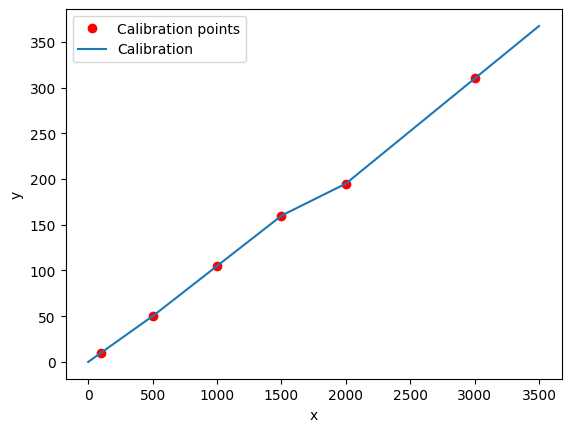

In [15]:
plt.figure()
plt.plot(points_x, points_y, "ro", label="Calibration points")
x_fine = np.linspace(0, 3500, num=1000)
plt.plot(x_fine, cal(x_fine), label=cal.__class__.__name__)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

# Inverse functions

You can provide an inverse function expression, if available, or the calibration will numerically estimate its inverse:

In [16]:
cal = Calibration("p[0] + p[1] * x", [5, 2], inv_expression="(y - p[0]) / p[1]")
print(cal)
print(cal(100.0))
print(cal.inverse(cal(100.0)))

expression:
    p[0] + p[1] * x
params (p):
    [5 2]
inv_expression:
    (y - p[0]) / p[1]
domain:
    (np.float64(-1000000.0), np.float64(1000000.0))
range:
    (np.float64(-1000000.0), np.float64(1000000.0))

205.0
100.0


In [17]:
cal = Calibration("p[0] + p[1] * x + p[2] * x ** 2", [5, 2, 1e-2], domain=[0, 3000])
print(cal)
print(cal(100.0))
print(cal.inverse(cal(100.0)))

expression:
    p[0] + p[1] * x + p[2] * x**2
params (p):
    [5.   2.   0.01]
domain:
    (np.int64(0), np.int64(3000))
range:
    (np.float64(-1000000.0), np.float64(1000000.0))

305.0
100.0


# Complex calibration function

This example includes the interpolation of a light yield curve using auxiliary parameters, and then the scaling of the result using calibration parameters.

In [18]:
aux = np.array(
    [
        [0.0, 1000, 1500, 2000],
        [0.0, 1000, 1400, 1800],
    ]
)
cal = Calibration(
    """
# light yield curve
f_x = a[0, :]
f_y = a[1, :]

# offset, gain, saturation
c, g, s = p[0], p[1], p[2]
z = (x - c) / (g - s * (x - c))

scipy.interpolate.CubicSpline(f_x, f_y)(z)
""",
    [-5.0, 1.0, 1e-6],
    aux_params=aux,
    domain=[0, 3000],
)

In [19]:
print(cal)
cal(1500)

expression:
    # light yield curve
    f_x = a[0, :]
    f_y = a[1, :]
    
    # offset, gain, saturation
    c, g, s = p[0], p[1], p[2]
    z = (x - c) / (g - s * (x - c))
    
    scipy.interpolate.CubicSpline(f_x, f_y)(z)
params (p):
    [-5.e+00  1.e+00  1.e-06]
auxiliary params (a):
    [[   0. 1000. 1500. 2000.]
 [   0. 1000. 1400. 1800.]]
domain:
    (np.int64(0), np.int64(3000))
range:
    (np.float64(-1000000.0), np.float64(1000000.0))



array(1405.69363615)

In [20]:
cal.add_points(points_x, points_y)
cal.fit(bounds=[(-10.0, 1e0, 0), (10.0, 1e2, 1e-4)])
print(cal)

expression:
    # light yield curve
    f_x = a[0, :]
    f_y = a[1, :]
    
    # offset, gain, saturation
    c, g, s = p[0], p[1], p[2]
    z = (x - c) / (g - s * (x - c))
    
    scipy.interpolate.CubicSpline(f_x, f_y)(z)
params (p):
    [1.00000000e+01 1.16422628e+01 1.00000000e-04]
auxiliary params (a):
    [[   0. 1000. 1500. 2000.]
 [   0. 1000. 1400. 1800.]]
domain:
    (np.int64(0), np.int64(3000))
range:
    (np.float64(-1000000.0), np.float64(1000000.0))
calibration points (x):
    [ 100.  500. 1000. 1500. 2000. 3000.]
calibration points (y):
    [ 10.  50. 105. 160. 195. 310.]
calibration weights:
    [1. 1. 1. 1. 1. 1.]



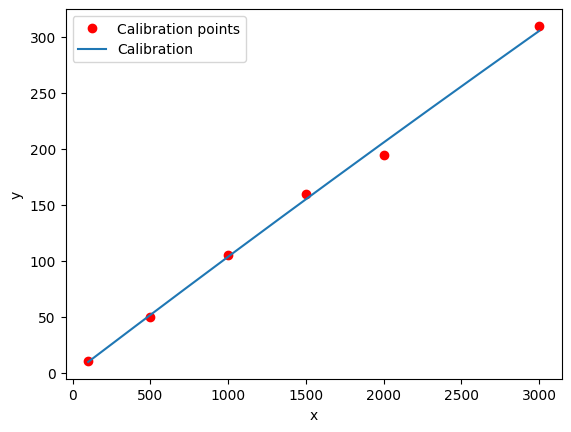

In [21]:
plt.figure()
plt.plot(points_x, points_y, "ro", label="Calibration points")
x_fine = np.linspace(min(points_x), max(points_x), num=1000)
plt.plot(x_fine, cal(x_fine), label=cal.__class__.__name__)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

# HDF5 I/O

Any `Calibration` can be written to and read from HDF5:

In [22]:
cal.write("test.h5")
print(cal)

expression:
    # light yield curve
    f_x = a[0, :]
    f_y = a[1, :]
    
    # offset, gain, saturation
    c, g, s = p[0], p[1], p[2]
    z = (x - c) / (g - s * (x - c))
    
    scipy.interpolate.CubicSpline(f_x, f_y)(z)
params (p):
    [1.00000000e+01 1.16422628e+01 1.00000000e-04]
auxiliary params (a):
    [[   0. 1000. 1500. 2000.]
 [   0. 1000. 1400. 1800.]]
domain:
    (np.int64(0), np.int64(3000))
range:
    (np.float64(-1000000.0), np.float64(1000000.0))
calibration points (x):
    [ 100.  500. 1000. 1500. 2000. 3000.]
calibration points (y):
    [ 10.  50. 105. 160. 195. 310.]
calibration weights:
    [1. 1. 1. 1. 1. 1.]



In [23]:
cal2 = Calibration.read("test.h5")
print(cal2)

expression:
    # light yield curve
    f_x = a[0, :]
    f_y = a[1, :]
    
    # offset, gain, saturation
    c, g, s = p[0], p[1], p[2]
    z = (x - c) / (g - s * (x - c))
    
    scipy.interpolate.CubicSpline(f_x, f_y)(z)
params (p):
    [1.00000000e+01 1.16422628e+01 1.00000000e-04]
auxiliary params (a):
    [[   0. 1000. 1500. 2000.]
 [   0. 1000. 1400. 1800.]]
domain:
    (np.int64(0), np.int64(3000))
range:
    (np.float64(-1000000.0), np.float64(1000000.0))
calibration points (x):
    [ 100.  500. 1000. 1500. 2000. 3000.]
calibration points (y):
    [ 10.  50. 105. 160. 195. 310.]
calibration weights:
    [1. 1. 1. 1. 1. 1.]



To demonstrate that `cal2` has the same information as `cal` does, we can check for equality:

In [24]:
cal2 == cal

True

And here is what a plot of `cal2` evaluated across the domain, which is identical to `cal`'s plot above:

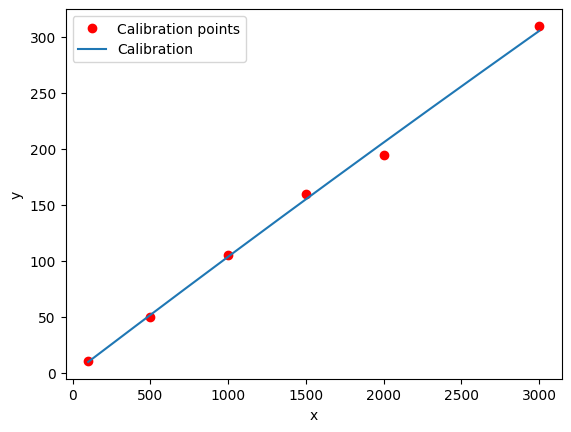

In [25]:
plt.figure()
plt.plot(points_x, points_y, "ro", label="Calibration points")
x_fine = np.linspace(min(points_x), max(points_x), num=1000)
plt.plot(x_fine, cal2(x_fine), label=cal2.__class__.__name__)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()